# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
# !pip install metatreelib


In [2]:
# pip install 1. Introductions

In [3]:
import sys
sys.path.append('..')

from metatree.model_metatree import LlamaForMetaTree as MetaTree
from metatree.decision_tree_class import DecisionTree, DecisionTreeForest
from metatree.run_train import preprocess_dimension_patch
from transformers import AutoConfig

from sklearn.metrics import accuracy_score
import sklearn
from gosdt import GOSDT

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imodels
import random

model_name_or_path = "yzhuang/MetaTree"

config = AutoConfig.from_pretrained(model_name_or_path)
model = MetaTree.from_pretrained(
    model_name_or_path,
    config=config,
)   
decision_tree_forest = DecisionTreeForest()

ensemble_size = 1
seed = 42

/home/thanhnguyen/PycharmProjects/scientificProject/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/thanhnguyen/PycharmProjects/scientificProject/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/thanhnguyen/PycharmProjects/scientificProject/venv/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [4]:
X, y, feature_names = imodels.get_clean_dataset('readmission_clean', data_source='imodels')

print("Dataset Shapes X={}, y={}, Num of Classes={}".format(X.shape, y.shape, len(set(y))))

train_idx, test_idx = sklearn.model_selection.train_test_split(range(X.shape[0]), test_size=0.3, random_state=seed)

# Dimension 
random.seed(seed)
feature_idx = np.random.choice(X.shape[1], 10, replace=False)
X = X[:, feature_idx]

test_X, test_y = X[test_idx], y[test_idx]

for i in range(ensemble_size):
    # Sample Train and Test Data
    random.seed(seed+i+1)
    subset_idx = random.sample(train_idx, 256)
    train_X, train_y = X[subset_idx], y[subset_idx]
    

    input_x = torch.tensor(train_X, dtype=torch.float32)
    input_y = torch.nn.functional.one_hot(torch.tensor(train_y)).float()

    batch = {"input_x": input_x, "input_y": input_y, "input_y_clean": input_y}
    batch = preprocess_dimension_patch(batch, n_feature=10, n_class=10)
    model.depth = 2
    outputs = model.generate_decision_tree(batch['input_x'], batch['input_y'], depth=model.depth)
    decision_tree_forest.add_tree(DecisionTree(auto_dims=outputs.metatree_dimensions, auto_thresholds=outputs.tentative_splits, input_x=batch['input_x'], input_y=batch['input_y'], depth=model.depth))

    print("Decision Tree Features: ", [x.argmax(dim=-1) for x in outputs.metatree_dimensions])
    print("Decision Tree Threasholds: ", outputs.tentative_splits)


Dataset Shapes X=(101763, 150), y=(101763,), Num of Classes=2
Decision Tree Features:  [tensor([8]), tensor([2]), tensor([8])]
Decision Tree Threasholds:  [tensor([[71.5000]]), tensor([[1.0000]]), tensor([[72.5000]])]


In [5]:


tree_pred = decision_tree_forest.predict(torch.tensor(test_X, dtype=torch.float32))

accuracy = accuracy_score(test_y, tree_pred.argmax(dim=-1).squeeze(0))
print("MetaTree Test Accuracy: ", accuracy)



MetaTree Test Accuracy:  0.5355891119918765


In [6]:
cart_ensemble = []

for i in range(ensemble_size):
    random.seed(seed+i+1)
    subset_idx = random.sample(train_idx, 256)
    train_X, train_y = X[subset_idx], y[subset_idx]
    
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=seed+i+1)
    clf.fit(train_X, train_y)
    cart_ensemble.append(clf)

overall_pred = np.zeros((test_X.shape[0], len(set(test_y))))
for clf in cart_ensemble:
    overall_pred += clf.predict_proba(test_X)
overall_pred = overall_pred / len(cart_ensemble)

accuracy = accuracy_score(test_y, overall_pred.argmax(axis=-1))
print("CART Test Accuracy: ", accuracy)


CART Test Accuracy:  0.5302171705591405


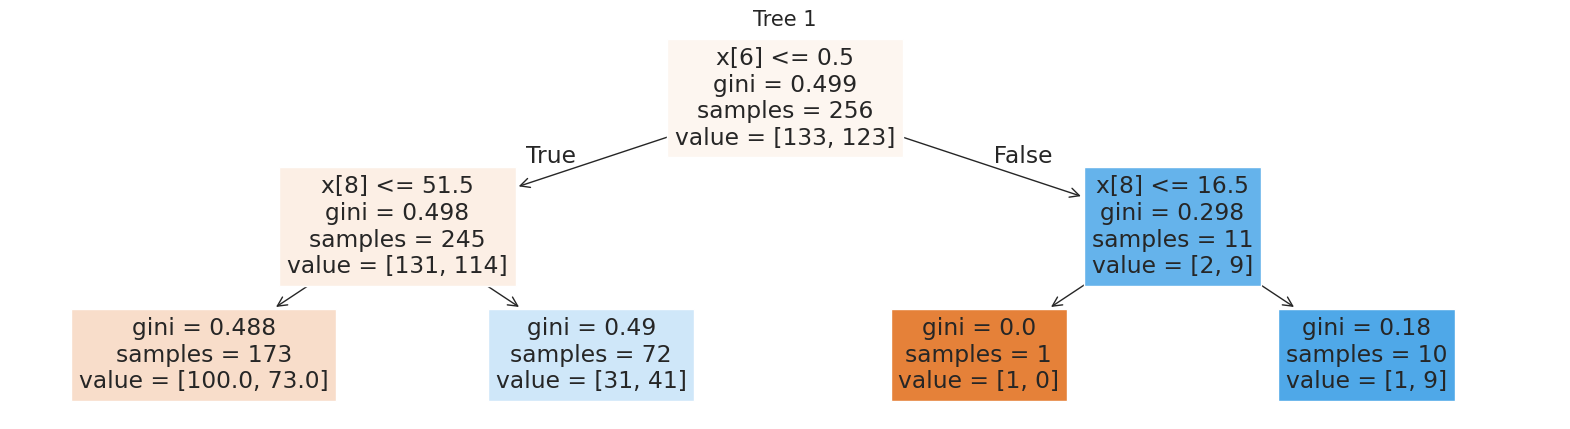

AttributeError: 'numpy.ndarray' object has no attribute 'insert'

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

# Thiết lập seaborn cho các biểu đồ đẹp hơn
sns.set(style="whitegrid")

# Số cây quyết định để vẽ, đảm bảo không vượt quá số lượng cây có trong cart_ensemble
num_trees_to_plot = min(3, len(cart_ensemble))

# Tạo các subplots
fig, axes = plt.subplots(nrows=1, ncols=num_trees_to_plot, figsize=(20, 5))

# Nếu chỉ có một cây, axes sẽ không phải là danh sách, cần chuyển đổi nó thành danh sách
if num_trees_to_plot == 1:
    axes = [axes]

# Vẽ các cây quyết định
for i in range(num_trees_to_plot):
    # Chọn một cây quyết định từ tập hợp
    clf = cart_ensemble[i]
    # Vẽ cây quyết định lên một subplot
    plot_tree(clf, filled=True, ax=axes[i])
    axes[i].set_title(f'Tree {i+1}', fontsize=15)

plt.show()



In [8]:
gosdt_params = {
    'regularization': 0.01,
    'time_limit': 60,  # giới hạn thời gian tính toán là 60 giây
    'verbose': True
}

# Khởi tạo mô hình GOSDT với các tham số đã định nghĩa
gosdt_model = GOSDT(gosdt_params)

# Huấn luyện mô hình GOSDT với tập dữ liệu huấn luyện
gosdt_model.fit(train_X, train_y)

# Dự đoán kết quả trên tập dữ liệu kiểm tra
predictions = gosdt_model.predict(test_X)

# Tính toán độ chính xác của mô hình
accuracy = accuracy_score(test_y, predictions)
print(f'Độ chính xác của mô hình GOSDT: {accuracy}')

AttributeError: 'numpy.ndarray' object has no attribute 'values'